# Analyze Social Node Structure 

Perform following structural analysis

    1. Get Egonet for top 10 Social Score nodes with diameter 3 
    2. Get list of nodes visited by random walk from 
    3. Perform k-core decomposition to identify key nodes check if top 10 social score nodes are in the list 
  

In [1]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import csv 

from datetime import datetime
from matplotlib.pyplot import loglog 

from modifiedSocialScore import GenerateGraph, GenerateDirectedNxGraph, GeneratePrunedDirectedGraph

%matplotlib inline


Top top nodes avg response score: [(1159, 0.12607449856733524, 349.0, 44.0), (453, 0.10272536687631027, 477.0, 49.0), (1287, 0.09381663113006397, 469.0, 44.0), (1669, 0.08834355828220859, 815.0, 72.0), (1874, 0.08074866310160428, 1870.0, 151.0), (895, 0.07534246575342465, 292.0, 22.0), (1833, 0.06930693069306931, 202.0, 14.0), (1277, 0.04895104895104895, 286.0, 14.0), (1963, 0.04807692307692308, 208.0, 10.0), (350, 0.03862660944206009, 233.0, 9.0)]

 Top 10 nodes based on weighted Clique size:  [(1874, 18960.87987360233), (1258, 7167.11953894776), (999, 5016.602713704208), (511, 4383.006651884702), (1963, 3709.6503496503506), (1669, 3114.022085889569), (453, 2473.729559748429), (1287, 2238.362473347549), (1440, 2072.403038537549), (1998, 1595.1740178698046)]


In [2]:
#
# Load adjacency list as a pandas dataframe 
#
df, _ = GenerateGraph(filename='/home/merchantsameer2014/project/dnc-temporalGraph/out.dnc-temporalGraph')

In [3]:
#
# Build a networkx directed multigraph 
#   - Edge represents src sent an email to destination 
#
GNx = GenerateDirectedNxGraph(df)

In [4]:
# 
# Build an networkx undirected graph of nodes that have exchanged more than 4 emails 
#
uGNx = GeneratePrunedDirectedGraph(GNx, N=4)
uGNx.remove_edges_from(nx.selfloop_edges(uGNx))

## Egonet analysis of top N nodes ranked based on social score... 

In [5]:
#
# Average shortest path length 
#
Gc = max(nx.connected_component_subgraphs(uGNx), key=len)
print "Average Shortest Path in email network: %r" % (nx.average_shortest_path_length(Gc))

Average Shortest Path in email network: 3.2480603654707805


In [25]:
#
# Load social score nodes 
#
socialNodes = list()
topN = 20

with open('socialScore_2.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter='\t')            
    for row in reader:
        #print row
        socialNodes.append((row[0], row[1]))  
        
nodes = [ int(node) for (node, _) in socialNodes[:topN]]

In [26]:
# 
# Compute Egnonet for top 50 nodes based on Social Score 
#
egoNetworks = dict()
egoNetNodes = dict()

for index, (node, _) in enumerate(socialNodes[:topN]):
    egoNetworks[index] = nx.ego_graph(uGNx, int(node), radius=1, undirected=True)   

    #
    # Generate list of egonet Nodes for each social scode node 
    #
    egoNetNodes[index] = set(egoNetworks[index].nodes)
       

In [27]:
overlapFractions = list()
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        common_nodes = egoNetNodes[i].intersection(egoNetNodes[j])
        #print "%r(%d), %r(%d), EgoNet Nodes common: %r" % (nodes[i], len(egoNetNodes[i]),\
        #                                                 nodes[j], len(egoNetNodes[j]), len(common_nodes))
        min_nodes = min(len(egoNetNodes[i]), len(egoNetNodes[j]))
        frac = float(len(common_nodes))/float(min_nodes)
        overlapFractions.append((nodes[i],nodes[j], frac))

overlapFractions.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)

for src, dst, frac in overlapFractions:
    if (frac >= 0.5):
        print "Nodes %r, %r: overlap: %r" % (src, dst, frac)

print "\n"
for n, s in socialNodes[:topN]:
    print "Node: %r, social score: %r" % (n,s)
   

Nodes 1874, 1974: overlap: 1.0
Nodes 1874, 411: overlap: 1.0
Nodes 1258, 1974: overlap: 1.0
Nodes 1258, 411: overlap: 1.0
Nodes 999, 1974: overlap: 1.0
Nodes 999, 411: overlap: 1.0
Nodes 1874, 1963: overlap: 0.9523809523809523
Nodes 1258, 1963: overlap: 0.9523809523809523
Nodes 999, 1963: overlap: 0.9523809523809523
Nodes 511, 1974: overlap: 0.9473684210526315
Nodes 1369, 411: overlap: 0.9411764705882353
Nodes 1874, 1258: overlap: 0.925
Nodes 1998, 1522: overlap: 0.9047619047619048
Nodes 999, 1522: overlap: 0.9047619047619048
Nodes 999, 1998: overlap: 0.896551724137931
Nodes 1998, 1974: overlap: 0.8947368421052632
Nodes 1369, 1974: overlap: 0.8947368421052632
Nodes 1974, 411: overlap: 0.8823529411764706
Nodes 511, 411: overlap: 0.8823529411764706
Nodes 1874, 1522: overlap: 0.8571428571428571
Nodes 1369, 1963: overlap: 0.8571428571428571
Nodes 511, 1963: overlap: 0.8571428571428571
Nodes 585, 1974: overlap: 0.8421052631578947
Nodes 999, 511: overlap: 0.8275862068965517
Nodes 1874, 852: 

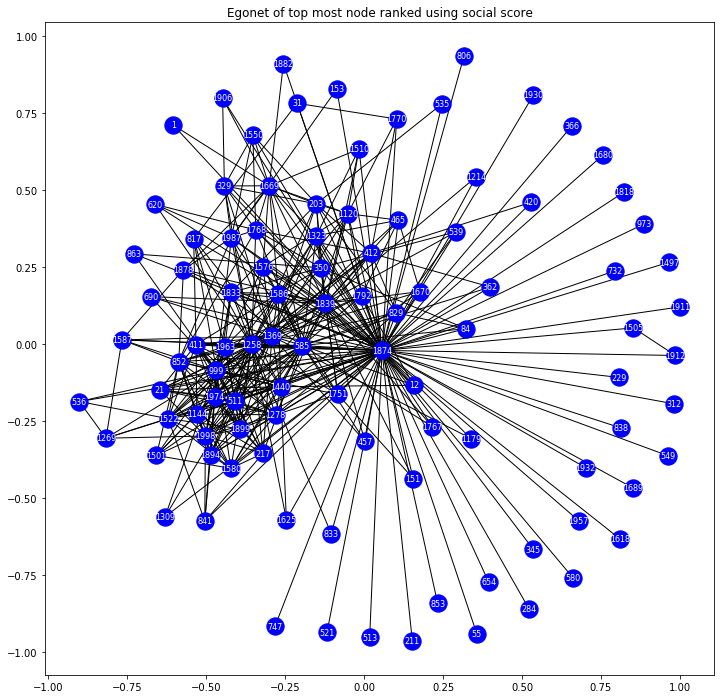

In [55]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of top most node ranked using social score")
nx.draw_networkx(egoNetworks[0], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()



In [ ]:
#
# Plot EgoNet of last node in top N Nodes ranked by social score 
#
plt.figure(figsize=(12,12))
nx.draw_networkx(egoNetworks[topN-1], node_color='b', with_labels=True, font_size=8, font_color='w')
# Draw ego as large and red
#nx.draw_networkx_nodes(egoNetworks[0], pos=nx.spring_layout(egoNetworks[0]), nodelist=[socialNodes[0][0]], node_size=400, node_color='r')
plt.show()

## k-core decomposition 

Analyze DNC email network. Identify central nodes in the network based on k-core decomposition 


Number of nodes in k=10 k-Core network: 20


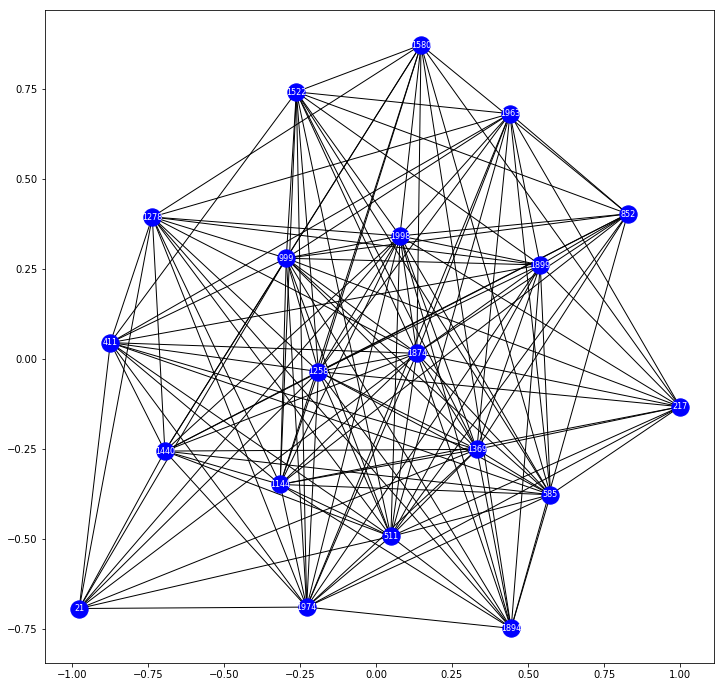

In [53]:
k = 10 
k_core_graph = nx.k_core(uGNx, k=k)
print "Number of nodes in k=%d k-Core network: %d" % (k, nx.number_of_nodes(k_core_graph))
plt.figure(figsize=(12,12))
nx.draw_networkx(k_core_graph, node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()

In [56]:
k_core_nodes = list(k_core_graph.nodes)
k_core_node_set = set(k_core_nodes)
tn = 20
nodes = [ int(node) for (node, _) in socialNodes[:tn]]
social_node_set = set(nodes)
#print k_core_node_set
#print social_node_set
common = social_node_set.intersection(k_core_node_set)
print "k=10 core network has total: %d nodes, %d nodes are common with top %d social nodes" % (len(k_core_nodes),\
                                                                                               len(common),\
                                                                                               tn)
print "Nodes not in k-core: %r" % (social_node_set - k_core_node_set)
print "Social nodes in k=10 core network: %r" % common

k=10 core network has total: 20 nodes, 14 nodes are common with top 20 social nodes
Nodes not in k-core: set([453, 1159, 1706, 1287, 1839, 1669])
Social nodes in k=10 core network: set([1440, 999, 585, 1258, 1963, 1522, 1998, 1874, 852, 1974, 1144, 1369, 411, 511])


In [57]:
egoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(len(nodes)):
    egoNetSize = len(list(egoNetworks[i].nodes))
    egoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/len(nodes)
print "Average Egonet size: %r, (Max:%r, min:%r)" % (avgEgoNetSize, max(egoNetDistribution), min(egoNetDistribution))


Average Egonet size: 44.3, (Max:100, min:17)


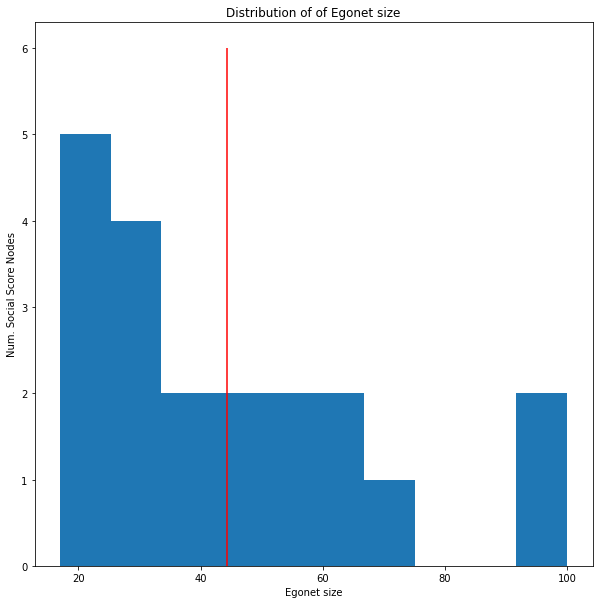

In [58]:
plt.figure(figsize=(10,10))
#plt.yscale('linear')
plt.title("Distribution of of Egonet size")
plt.xlabel('Egonet size')
plt.ylabel('Num. Social Score Nodes')
plt.vlines(avgEgoNetSize, 0, 6, color='r')
plt.hist(egoNetDistribution)
plt.show()